# Sparkify Project Workspace
This workspace contains a tiny subset (128MB) of the full dataset available (12GB). Feel free to use this workspace to build your project, or to explore a smaller subset with Spark before deploying your cluster on the cloud. Instructions for setting up your Spark cluster is included in the last lesson of the Extracurricular Spark Course content.

You can follow the steps below to guide your data analysis and model building portion of this project.

In [8]:
# import libraries
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, concat, count, lit, udf, avg
from sklearn.metrics import classification_report

import datetime

import numpy as np
import pandas as pd
%matplotlib inline
import matplotlib.pyplot as plt
import seaborn as sb


# Load and Clean Dataset
In this workspace, the mini-dataset file is `mini_sparkify_event_data.json`. Load and clean the dataset, checking for invalid or missing data - for example, records without userids or sessionids. 

In [2]:
    # create a Spark session
    spark = SparkSession.builder \
        .master("local") \
        .appName("sparkify") \
        .getOrCreate()

In [3]:
database_filepath = "mini_sparkify_event_data.json"

In [41]:
def load_data(database_filepath):
    '''
    The function creates a Spark session and loads the dataset from the json file into spark.
    '''
    user_log = spark.read.json(database_filepath) # database_filepath = "mini_sparkify_event_data.json"
    return user_log
    pass
df = load_data('mini_sparkify_event_data.json')

In [42]:
def clean_data(user_log):
    '''
    The function drops rows ["userId", "sessionId"] have Missing Values or empty from the inputed dataset
                 add new cols ('Churn','chgrd','time_gap','sex') into dataset
                 flag 'cancelled user' as 1, 'others' as 0 in col 'Churn'
                 flag 'paid' usage in col 'chgrd'
                 flag 'gender' in numeric format in col 'chgrd'
                 get usage time by calculate max(ts) - min(ts) per user and saved the result in col 'time_gap'
    '''
    # drop rows ["userId", "sessionId"] have Missing Values or empty
    user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
    user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

    # find whether users Cancellation Confirmation and then flag'cancelled user' as 1, 'others' as 0 in 'Churn'.
    flag_Cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("Churn", flag_Cancel_event("page"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    user_log_valid = user_log_valid.withColumn("Churn", Fsum("Churn").over(windowval))

    # get numbers of page operations when the users' level = 'paid' and saved the numbers in column 'chgrd'.
    flag_changegrade_event = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("chgrd", flag_changegrade_event("level"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    user_log_valid = user_log_valid.withColumn("chgrd", Fsum("chgrd").over(windowval))

    # identify users' gender, flag male as 1 and female as 0 in 'sex'
    flag_gender_event = udf(lambda x: 1 if x == "M" else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("sex", flag_gender_event("gender"))

    # create a temporary View and run SQL queries to get cleaned data df
    user_log_valid.createOrReplaceTempView("user_log_valid_table")
    # cleaned data includes user Id, genda, paid usage(chrgd), users' stay time (time_gap), and cancel or not flag (Churn)
    df = spark.sql(
        '''
        select t1.userId,sex,chgrd,time_gap,Churn,gender
        from user_log_valid_table t1
        join
         (select userId, max(chgrd) as mchgrd,(max(ts) - min(ts))/1000 as time_gap
         from user_log_valid_table
         group by userId) t2
        on (t1.userId == t2.userId and t1.chgrd == t2.mchgrd)
        order by Churn
        '''
                      ).dropDuplicates()
    return df
    pass

df = clean_data(df)

In [15]:
#Not used in the main()
# Get YYYY-MM-DD-HH 
get_YYYY = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). year)
get_MM = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). month)
get_DD = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). day)
get_HH = udf(lambda x: datetime.datetime.fromtimestamp(x / 1000.0). hour)

#user_log = user_log.withColumn("Hour", get_HH(user_log.ts))
#user_log = user_log.withColumn('Year',get_YYYY(user_log.ts))
#user_log = user_log.withColumn('Month',get_MM(user_log.ts))
#user_log = user_log.withColumn('Day',get_DD(user_log.ts))
#user_log.show()

# add 'state' column
#splt = udf(lambda x:x.split(',')[1][1:3])
#user_log_valid = user_log_valid.withColumn('ST',splt('location'))
#user_log_valid.select('ST').show()

#x = 2060011
#datetime.datetime.fromtimestamp(x).day

# Exploratory Data Analysis
When you're working with the full dataset, perform EDA by loading a small subset of the data and doing basic manipulations within Spark. In this workspace, you are already provided a small subset of data you can explore.

### Define Churn

Once you've done some preliminary analysis, create a column `Churn` to use as the label for your model. I suggest using the `Cancellation Confirmation` events to define your churn, which happen for both paid and free users. As a bonus task, you can also look into the `Downgrade` events.

### Explore Data
Once you've defined churn, perform some exploratory data analysis to observe the behavior for users who stayed vs users who churned. You can start by exploring aggregates on these two groups of users, observing how much of a specific action they experienced per a certain time unit or number of songs played.

In [43]:
def explore_data(df):
    '''
    The function displays the Sex distribution,Usage Time distribution,
    and paid usage Distribution between cancled users and noncancled users
    '''
    # display the sex distribution between cancled users and noncancled users
    print('Insights:\n 1 Sex Disparity of Cancled User \n')
    df.groupby(['Churn','sex']).count().show()

    # display the usage time distribution between cancled users and noncancled users
    print('\n 2 Usage Time Distribution \n')
    df.groupby('Churn').avg('time_gap').show()

    # display the paid usage (average of 'chgrd')distribution between cancled users and noncancled users
    print('\n 3 Usage paid usage Distribution \n')
    df.groupby('Churn').avg('chgrd').show()

    pass
explore_data(df)

Insights:
 1 Sex Disparity of Cancled User 

+-----+---+-----+
|Churn|sex|count|
+-----+---+-----+
|    0|  1|   89|
|    0|  0|   84|
|    1|  1|   32|
|    1|  0|   20|
+-----+---+-----+


 2 Usage Time Distribution 

+-----+-----------------+
|Churn|    avg(time_gap)|
+-----+-----------------+
|    0|4060011.456647399|
|    1|2031665.576923077|
+-----+-----------------+


 3 Usage paid usage Distribution 

+-----+------------------+
|Churn|        avg(chgrd)|
+-----+------------------+
|    0|1098.0173410404625|
|    1| 624.5384615384615|
+-----+------------------+



In [44]:
df = df.toPandas()

In [65]:
df.describe()

,sex,chgrd,time_gap,Churn
count,225.000000,225.000000,2.250000e+02,225.000000
mean,0.537778,988.591111,3.591238e+06,0.231111
std,0.499682,1238.578647,1.642798e+06,0.422483
min,0.000000,0.000000,4.200000e+02,0.000000
25%,0.000000,0.000000,2.529851e+06,0.000000
50%,1.000000,541.000000,4.299395e+06,0.000000
75%,1.000000,1630.000000,4.927081e+06,0.000000
max,1.000000,7779.000000,5.270203e+06,1.000000


Text(0,0.5,'Count')

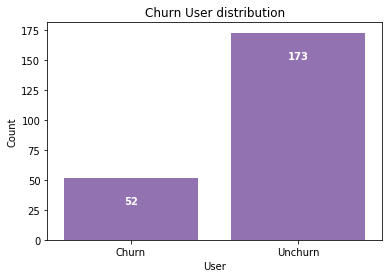

In [143]:
base_color = sb.color_palette()[4]
ct = df.groupby(['Churn'])['userId'].count()
#ct.index.values
#np.array(ct)
sb.barplot(data = ct, x = ct.index.values, y = np.array(ct),color = base_color)
for i in range(2):
    plt.text(i,np.array(ct)[1-i]-20,np.array(ct)[1-i],ha = 'center', va='center',color='white',weight='bold')
plt.xticks([0,1],['Churn','Unchurn'])
plt.title('Churn User distribution')
plt.xlabel('User')
plt.ylabel('Count')

Text(0.5,0,'User')

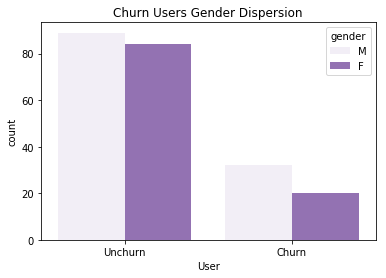

In [169]:
sb.countplot(data = df, x = 'Churn', hue = 'gender',color = base_color)
plt.title('Churn Users Gender Dispersion')
plt.xticks([0,1],['Unchurn','Churn'])
plt.xlabel('User')

([<matplotlib.axis.XTick at 0x7f94970abda0>,
 <a list of 2 Text xticklabel objects>)

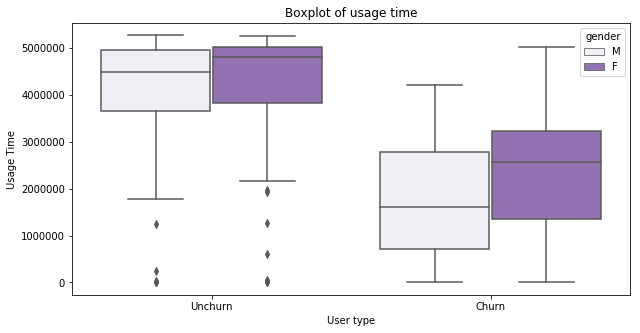

In [111]:
plt.figure(figsize = [10, 5])
sb.boxplot(data=df, x='Churn', y='time_gap', hue = 'gender',color = base_color)
plt.title('Boxplot of usage time')
plt.xlabel('User type')
plt.ylabel('Usage Time')
plt.xticks([0,1],['Unchurn', 'Churn'])

# Feature Engineering
Once you've familiarized yourself with the data, build out the features you find promising to train your model on. To work with the full dataset, you can follow the following steps.
- Write a script to extract the necessary features from the smaller subset of data
- Ensure that your script is scalable, using the best practices discussed in Lesson 3
- Try your script on the full data set, debugging your script if necessary

If you are working in the classroom workspace, you can just extract features based on the small subset of data contained here. Be sure to transfer over this work to the larger dataset when you work on your Spark cluster.

In [34]:
# Using PCA to reduce the dim of 3d vectors to 2d. 
def feature_engi(df):
    '''
    The function Combine the gender, usage time, and paid usage columns into a vector,
    and Scales the Vectors
    '''
    #Combine the gender, usage time, and paid usage columns into a vector
    assembler = VectorAssembler(inputCols=["sex","time_gap","chgrd"], outputCol="NumFeatures")
    df = assembler.transform(df)
    pca = PCA(k=2, inputCol="NumFeatures", outputCol="pca") # k is the number of dims
    model = pca.fit(df)
    df = model.transform(df)
    #Scale the Vectors
    scaler = StandardScaler(inputCol="pca", outputCol="features",withMean=True, withStd=False)
    scalerModel = scaler.fit(df)
    df = scalerModel.transform(df)
    return df
    pass

#Evaluation result:  Accuracy:
'''
0.8461538461538461
 Confusion Matrix:
               precision    recall  f1-score   support

        0.0       0.90      0.90      0.90        21
        1.0       0.60      0.60      0.60         5

avg / total       0.85      0.85      0.85        26
'''

In [42]:
# Choose 2 features instead 3, the evaluation result is better.
def feature_engi_2(df):
    '''
    The function Combine the gender, usage time into a vector,
    and Scales the Vectors
    '''
    #Combine the gender, usage time, and paid usage columns into a vector
    assembler = VectorAssembler(inputCols=["sex","time_gap"], outputCol="NumFeatures")
    df = assembler.transform(df)

    #Scale the Vectors
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="features",withMean=True, withStd=False)
    scalerModel = scaler.fit(df)
    df = scalerModel.transform(df)
    return df
    pass
'''
result

result:
Accuracy:

0.7619047619047619
 Confusion Matrix:
               precision    recall  f1-score   support

        0.0       0.87      0.81      0.84        16
        1.0       0.50      0.60      0.55         5

avg / total       0.78      0.76      0.77        21

'''


In [10]:
def feature_engi_1(df):
    '''
    The function Combine the gender, usage time into a vector,
    and Scales the Vectors
    '''
    #Combine the gender, usage time, and paid usage columns into a vector
    assembler = VectorAssembler(inputCols=["sex","time_gap",'chgrd'], outputCol="features")
    df = assembler.transform(df)

    return df
    pass
'''
 Accuracy:result from "sex","time_gap"

0.8260869565217391
 Confusion Matrix:
               precision    recall  f1-score   support

        0.0       0.86      0.95      0.90        20
        1.0       0.00      0.00      0.00         3

avg / total       0.75      0.83      0.79        23
'''

''' Result of 
 Accuracy:"sex","time_gap",'chgrd'

0.7647058823529411
 Confusion Matrix:
               precision    recall  f1-score   support

        0.0       0.80      0.92      0.86        13
        1.0       0.50      0.25      0.33         4

avg / total       0.73      0.76      0.73        17
'''


'\n Accuracy:\n\n0.8260869565217391\n Confusion Matrix:\n               precision    recall  f1-score   support\n\n        0.0       0.86      0.95      0.90        20\n        1.0       0.00      0.00      0.00         3\n\navg / total       0.75      0.83      0.79        23\n'

In [27]:
#Not used
#Normalize the Vectors
scaler = Normalizer(inputCol="NumFeatures", outputCol="features")
df = scaler.transform(df)
    
#Scale the Vectors
scaler = StandardScaler(inputCol="NumFeatures", outputCol="features",withMean=True, withStd=False)
scalerModel = scaler.fit(df)
df = scalerModel.transform(df)

# Modeling
Split the full dataset into train, test, and validation sets. Test out several of the machine learning methods you learned. Evaluate the accuracy of the various models, tuning parameters as necessary. Determine your winning model based on test accuracy and report results on the validation set. Since the churned users are a fairly small subset, I suggest using F1 score as the metric to optimize.

In [11]:
def build_model():
    '''
    The function build model with
    machine pipeline which take in the combined and scaled vector column "ScaledNumFeatures" as input and output
    classification results on the 2 labels("Churn") in the dataset.
    '''
    indexer = StringIndexer(inputCol="Churn", outputCol="label")
    lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
    pipeline = Pipeline(stages=[indexer,lr])
    #tune model
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam,[0.0, 0.1]) \
        .addGrid(lr.maxIter,[10,20]) \
        .build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    return crossval
    pass
df = feature_engi(df)
model = build_model()

In [12]:
rest, validation = df.randomSplit([0.9, 0.1])

In [13]:
cvmodel = model.fit(rest)

In [32]:
def getBestParam(cvModel):
    '''
    The function gets the best parameter of cvModel
    '''
    params = cvModel.getEstimatorParamMaps()
    avgMetrics = cvModel.avgMetrics

    all_params = list(zip(params, avgMetrics))
    best_param = sorted(all_params, key=lambda x: x[1], reverse=True)[0]
    return best_param

best_param = getBestParam(cvmodel)[0]
for p, v in best_param.items():
	print("{} : {}".format(p.name, v))


regParam : 0.0
maxIter : 10


In [15]:
def evaluate_model(model, validation):
    '''
    The function reports the accuracy of the model prediction against validation dataset
    '''
    results = model.transform(validation)
    # using classification_report to get F1 score
    labels = np.unique(results.select ('prediction').collect())
    confusion_mat = classification_report(results.select ('label').collect(), results.select ('prediction').collect(),labels=labels)
   # print(" Accuracy:")
   # print((results.filter(results.label == results.prediction).count())/(results.count()))
    print("\n Confusion Matrix:\n ", confusion_mat)
    return results
    pass
results = evaluate_model(cvmodel, validation)

 Accuracy:

0.7647058823529411
 Confusion Matrix:
               precision    recall  f1-score   support

        0.0       0.80      0.92      0.86        13
        1.0       0.50      0.25      0.33         4

avg / total       0.73      0.76      0.73        17



In [59]:
import pickle
def save_model(model, model_filepath):
    '''
    The function export tained model as a pickle file
    '''
    s = pickle.dumps(model.avgMetrics)
    with open(model_filepath,'wb+') as f: # mode is'wb+'，represents binary writen
        f.write(s)
    pass
save_model(cvmodel, 'cls.pkl')

In [80]:
#results_pd = results.toPandas()
labels = np.unique(result.select ('prediction').toPandas()collect())
confusion_mat = classification_report(result.select ('label').collect(), result.select ('prediction').collect(),labels=labels)

# Final Steps
Clean up your code, adding comments and renaming variables to make the code easier to read and maintain. Refer to the Spark Project Overview page and Data Scientist Capstone Project Rubric to make sure you are including all components of the capstone project and meet all expectations. Remember, this includes thorough documentation in a README file in a Github repository, as well as a web app or blog post.

In [24]:
#Sparkify Project Workspace
# import libraries
import sys
from pyspark.sql import SparkSession
from pyspark.sql import Window
from pyspark.sql.functions import udf
from pyspark.sql.types import StringType
from pyspark.sql.types import IntegerType
from pyspark.sql.functions import desc
from pyspark.sql.functions import asc
from pyspark.sql.functions import sum as Fsum
from pyspark.ml.feature import CountVectorizer, IDF, Normalizer, PCA, RegexTokenizer, StandardScaler, StopWordsRemover, StringIndexer, VectorAssembler
from pyspark.ml import Pipeline
from pyspark.ml.regression import LinearRegression
from pyspark.ml.classification import LogisticRegression
from pyspark.ml.tuning import CrossValidator, ParamGridBuilder
from pyspark.ml.evaluation import MulticlassClassificationEvaluator
from pyspark.sql.functions import col, concat, count, lit, udf, avg
from sklearn.metrics import classification_report

import datetime

import numpy as np
import pandas as pd
# % matplotlib inline
import matplotlib.pyplot as plt

def load_data(database_filepath):
    '''
    The function creates a Spark session and loads the dataset from the json file into spark.
    '''
    user_log = spark.read.json(database_filepath) # database_filepath = "mini_sparkify_event_data.json"
    return user_log
    pass

def clean_data(user_log):
    '''
    The function drops rows ["userId", "sessionId"] have Missing Values or empty from the inputed dataset
                 add new cols ('Churn','chgrd','time_gap','sex') into dataset
                 flag 'cancelled user' as 1, 'others' as 0 in col 'Churn'
                 flag 'paid' usage in col 'chgrd'
                 flag 'gender' in numeric format in col 'chgrd'
                 get usage time by calculate max(ts) - min(ts) per user and saved the result in col 'time_gap'
    '''
    # drop rows ["userId", "sessionId"] have Missing Values or empty
    user_log_valid = user_log.dropna(how = "any", subset = ["userId", "sessionId"])
    user_log_valid = user_log_valid.filter(user_log_valid["userId"] != "")

    # find whether users Cancellation Confirmation and then flag'cancelled user' as 1, 'others' as 0 in 'Churn'.
    flag_Cancel_event = udf(lambda x: 1 if x == "Cancellation Confirmation" else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("Churn", flag_Cancel_event("page"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    user_log_valid = user_log_valid.withColumn("Churn", Fsum("Churn").over(windowval))

    # get numbers of page operations when the users' level = 'paid' and saved the numbers in column 'chgrd'.
    flag_changegrade_event = udf(lambda x: 1 if x == 'paid' else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("chgrd", flag_changegrade_event("level"))
    windowval = Window.partitionBy("userId").orderBy(desc("ts")).rangeBetween(Window.unboundedPreceding, 0)
    user_log_valid = user_log_valid.withColumn("chgrd", Fsum("chgrd").over(windowval))

    # identify users' gender, flag male as 1 and female as 0 in 'sex'
    flag_gender_event = udf(lambda x: 1 if x == "M" else 0, IntegerType())
    user_log_valid = user_log_valid.withColumn("sex", flag_gender_event("gender"))

    # create a temporary View and run SQL queries to get cleaned data df
    user_log_valid.createOrReplaceTempView("user_log_valid_table")
    # cleaned data includes user Id, genda, paid usage(chrgd), users' stay time (time_gap), and cancel or not flag (Churn)
    df = spark.sql(
        '''
        select t1.userId,sex,chgrd,time_gap,Churn
        from user_log_valid_table t1
        join
         (select userId, max(chgrd) as mchgrd,(max(ts) - min(ts))/1000 as time_gap
         from user_log_valid_table
         group by userId) t2
        on (t1.userId == t2.userId and t1.chgrd == t2.mchgrd)
        order by Churn
        '''
                      ).dropDuplicates()
    return df
    pass

def explore_data(df):
    '''
    The function displays the Sex distribution,Usage Time distribution,
    and paid usage Distribution between cancled users and noncancled users
    '''
    # display the sex distribution between cancled users and noncancled users
    print('Insights:\n 1 Sex Disparity of Cancled User \n')
    df.groupby(['Churn','sex']).count().show()

    # display the usage time distribution between cancled users and noncancled users
    print('\n 2 Usage Time Distribution \n')
    df.groupby('Churn').avg('time_gap').show()

    # display the paid usage (average of 'chgrd')distribution between cancled users and noncancled users
    print('\n 3 Usage paid usage Distribution \n')
    df.groupby('Churn').avg('chgrd').show()

    pass

def feature_engi(df):
    '''
    The function Combine the gender, usage time, and paid usage columns into a vector,
    and Scales the Vectors
    '''
    #Combine the gender, usage time, and paid usage columns into a vector
    assembler = VectorAssembler(inputCols=["sex","time_gap","chgrd"], outputCol="NumFeatures")
    df = assembler.transform(df)
    #Scale the Vectors
    scaler = StandardScaler(inputCol="NumFeatures", outputCol="features",withMean=True, withStd=False)
    scalerModel = scaler.fit(df)
    df = scalerModel.transform(df)
    return df
    pass

def build_model():
    '''
    The function build model with
    machine pipeline which take in the combined and scaled vector column "ScaledNumFeatures" as input and output
    classification results on the 2 labels("Churn") in the dataset.
    '''
    indexer = StringIndexer(inputCol="Churn", outputCol="label")
    lr =  LogisticRegression(maxIter=10, regParam=0.0, elasticNetParam=0)
    pipeline = Pipeline(stages=[indexer,lr])
    #tune model
    paramGrid = ParamGridBuilder() \
        .addGrid(lr.regParam,[0.0, 0.1]) \
        .addGrid(lr.maxIter,[10, 20]) \
        .build()
    crossval = CrossValidator(estimator=pipeline,
                              estimatorParamMaps=paramGrid,
                              evaluator=MulticlassClassificationEvaluator(),
                              numFolds=3)
    return crossval
    pass

def evaluate_model(model, validation):
     '''
    The function reports the accuracy of the model prediction against validation dataset
    '''
    results = model.transform(validation)
    # using classification_report to get F1 score
    labels = np.unique(results.select ('prediction').collect())
    confusion_mat = classification_report(results.select ('label').collect(), results.select ('prediction').collect(),labels=labels)
    print(" Accuracy:\n")
    print((results.filter(results.label == results.prediction).count())/(results.count()))
    print(" Confusion Matrix:\n ", confusion_mat)
    return results
    pass

def save_model(model, model_filepath):
    '''
    The function export tained model as a pickle file
    '''
    s = pickle.dumps(model)
    with open(model_filepath,'wb+') as f: # mode is'wb+'，represents binary writen
        f.write(s)
    pass

def main():
    '''
    The main() function combines and executes all the above modules.
    '''
    # create a Spark session
    spark = SparkSession.builder \
        .master("local") \
        .appName("sparkify") \
        .getOrCreate()
    database_filepath, model_filepath = sys.argv[1:]
    print('Loading data...\n    DATABASE: {}'.format(database_filepath))
    user_log = load_data(database_filepath)

    # Train Test Split
    #break data set into 90% of training data and set aside 10%. Set random seed to 42.
    rest, validation = df.randomSplit([0.9, 0.1], seed=42)

    print('Building model...')
    model = build_model()

    #Train pipeline
    print('Training model...')
    model.fit(rest)

    print('Evaluating model...')
    evaluate_model(validation)

    print('Saving model...\n    MODEL: {}'.format(model_filepath))
    save_model(model, model_filepath)

    print('Trained model saved!')

if __name__ == '__main__':
    main()


Loading data...
    DATABASE: -f


AnalysisException: 'Path does not exist: file:/home/workspace/-f;'